In [5]:
import sys
print("Installing into:", sys.executable)
!{sys.executable} -m pip install --quiet --upgrade pip
!{sys.executable} -m pip install --quiet scikit-learn umap-learn


Installing into: c:\Users\mdevr\AppData\Local\Programs\Python\Python312\python.exe


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import zipfile

print("Libraries imported successfully!")

Libraries imported successfully!


In [8]:
import os

# Define the path to your local dataset
dataset_path = 'PCA_Dataset'

if os.path.exists(dataset_path):
    print(f"Dataset found at: '{dataset_path}'")
else:
    print(f"Error: Dataset folder '{dataset_path}' not found.")
    print("Please make sure the folder is in the correct location.")

Dataset found at: 'PCA_Dataset'


In [9]:
def load_dataset(path):
    """Loads the AT&T Face Dataset from the specified path."""
    images = []
    labels = []
    # Assumes the dataset contains folders s1, s2, ..., s40
    for i in range(1, 41):
        subject_dir = os.path.join(path, f's{i}')
        # Assumes each subject has 10 images 1.pgm, 2.pgm, ...
        for j in range(1, 11):
            img_path = os.path.join(subject_dir, f'{j}.pgm')
            # Open image, convert to grayscale, and then to a numpy array
            img = Image.open(img_path)
            # Flatten the 112x92 image into a 10304-element vector
            images.append(np.array(img).flatten())
            labels.append(i-1) # Labels from 0 to 39
    return np.array(images), np.array(labels)

# Load the images and labels
images, labels = load_dataset(dataset_path)
print(f"Loaded {images.shape[0]} images.")
print(f"Each image is a vector of size {images.shape[1]}.")

# Split the dataset into training and testing sets (80% train, 20% test)
# stratify=labels ensures that the proportion of each subject is the same in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Loaded 400 images.
Each image is a vector of size 10304.
Training set shape: (320, 10304)
Testing set shape: (80, 10304)


In [10]:
# 1. Standardize the training data (zero mean)
mean_face = np.mean(X_train, axis=0)
X_train_std = X_train - mean_face
X_test_std = X_test - mean_face # Use the training mean to standardize the test set

# 2. Compute the covariance matrix
# Since the number of features (10304) is much larger than the number of samples (320),
# computing the covariance matrix X.T @ X would be computationally expensive (10304x10304).
# We use a trick: compute the covariance of X @ X.T (320x320), find its eigenvectors,
# and then project them back to the original space. This is much faster.
L = X_train_std @ X_train_std.T
eigenvalues, eigenvectors_L = np.linalg.eig(L)

# Project eigenvectors of L back to the original high-dimensional space
eigenvectors = X_train_std.T @ eigenvectors_L
# Normalize the eigenvectors to be unit vectors
eigenvectors = eigenvectors / np.linalg.norm(eigenvectors, axis=0)

# 3. Sort eigenvectors by descending eigenvalues
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

print("PCA implementation complete.")
print(f"Shape of eigenvectors matrix: {sorted_eigenvectors.shape}")

PCA implementation complete.
Shape of eigenvectors matrix: (10304, 320)


In [11]:
def knn_1nn_predict(X_train_proj, y_train, X_test_proj):
    dists = np.sum((X_test_proj[:, None, :] - X_train_proj[None, :, :])**2, axis=2)
    nn_idx = np.argmin(dists, axis=1)
    return y_train[nn_idx]


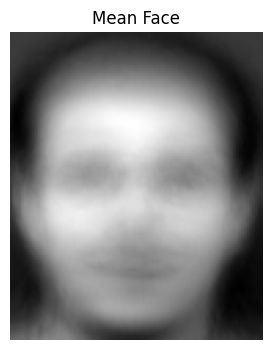

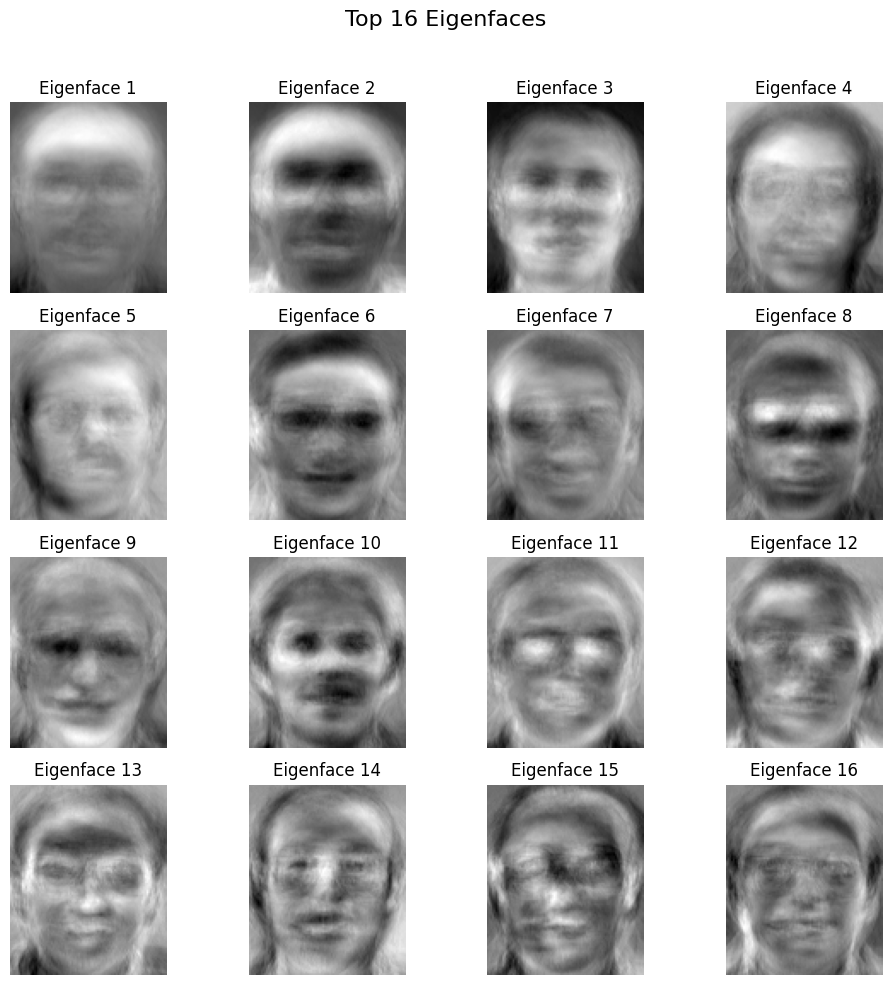

In [12]:
# Reshape function for plotting
def reshape_for_plot(vector):
    return vector.reshape(112, 92)

# Display the mean face
plt.figure(figsize=(4, 4))
plt.imshow(reshape_for_plot(mean_face), cmap='gray')
plt.title("Mean Face")
plt.axis('off')
plt.show()

# Visualize the first 16 Eigenfaces
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    # We take the real part as eigenvectors from np.linalg.eig can be complex
    ax.imshow(reshape_for_plot(sorted_eigenvectors[:, i].real), cmap='gray')
    ax.set_title(f"Eigenface {i+1}")
    ax.axis('off')
plt.suptitle("Top 16 Eigenfaces", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

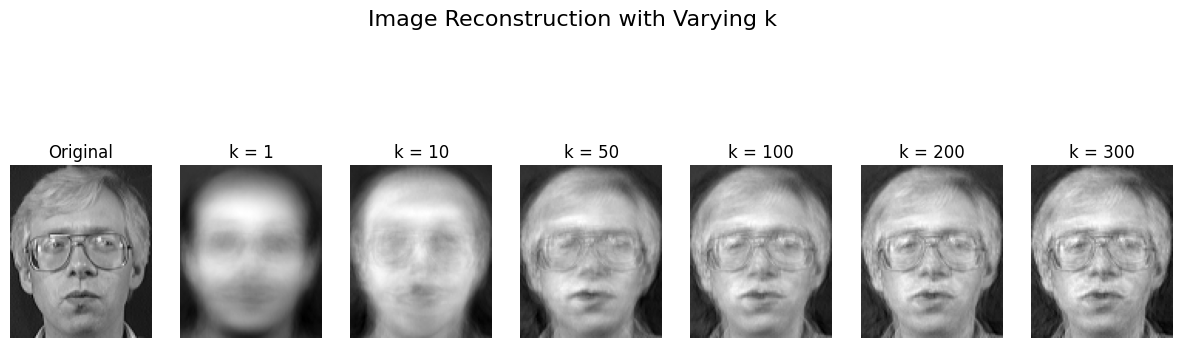

In [13]:
def project(data_std, eigenvectors, k):
    """Projects data onto the top k eigenvectors."""
    top_k_eigenvectors = eigenvectors[:, :k]
    return data_std @ top_k_eigenvectors

def reconstruct(projected_data, eigenvectors, k, mean_face):
    """Reconstructs data from its projected form."""
    top_k_eigenvectors = eigenvectors[:, :k]
    reconstructed_std = projected_data @ top_k_eigenvectors.T
    return reconstructed_std + mean_face

# Choose a test image to reconstruct
test_image_index = 0
original_image = X_test[test_image_index]
standardized_image = X_test_std[test_image_index]

# Reconstruct using different numbers of components (k)
k_values = [1, 10, 50, 100, 200, 300]
reconstructed_images = []

for k in k_values:
    projected = project(standardized_image, sorted_eigenvectors.real, k)
    reconstructed = reconstruct(projected, sorted_eigenvectors.real, k, mean_face)
    reconstructed_images.append(reconstructed)

# Plot the results
fig, axes = plt.subplots(1, len(k_values) + 1, figsize=(15, 5))
axes[0].imshow(reshape_for_plot(original_image), cmap='gray')
axes[0].set_title("Original")
axes[0].axis('off')

for i, img in enumerate(reconstructed_images):
    axes[i+1].imshow(reshape_for_plot(img), cmap='gray')
    axes[i+1].set_title(f"k = {k_values[i]}")
    axes[i+1].axis('off')

plt.suptitle("Image Reconstruction with Varying k", fontsize=16)
plt.show()

In [14]:
#Face Recognition using Nearest Neighbor (Task 5)
def nearest_neighbor_classifier(projected_train, y_train, projected_test_image):
    """Finds the label of the nearest training image."""
    # Calculate Euclidean distances
    distances = np.linalg.norm(projected_train - projected_test_image, axis=1)
    # Get the index of the minimum distance
    nearest_neighbor_index = np.argmin(distances)
    # Return the label of that training image
    return y_train[nearest_neighbor_index]

def calculate_accuracy(k, X_train_std, y_train, X_test_std, y_test, eigenvectors):
    """Calculates recognition accuracy for a given k."""
    # Select the top k eigenvectors
    eigenvectors_k = eigenvectors.real[:, :k]
    
    # Project both training and testing data into the face space
    projected_train = X_train_std @ eigenvectors_k
    projected_test = X_test_std @ eigenvectors_k
    
    correct_predictions = 0
    for i in range(len(projected_test)):
        predicted_label = nearest_neighbor_classifier(projected_train, y_train, projected_test[i])
        if predicted_label == y_test[i]:
            correct_predictions += 1
            
    return correct_predictions / len(y_test)

# Test the accuracy for k=100
k_test = 100
accuracy = calculate_accuracy(k_test, X_train_std, y_train, X_test_std, y_test, sorted_eigenvectors)
print(f"Recognition Accuracy for k={k_test}: {accuracy * 100:.2f}%")

Recognition Accuracy for k=100: 95.00%


Calculating accuracies for different k values...
  k=1, Accuracy=7.50%
  k=26, Accuracy=95.00%
  k=51, Accuracy=96.25%
  k=76, Accuracy=95.00%
  k=101, Accuracy=95.00%
  k=126, Accuracy=96.25%
Calculation complete.


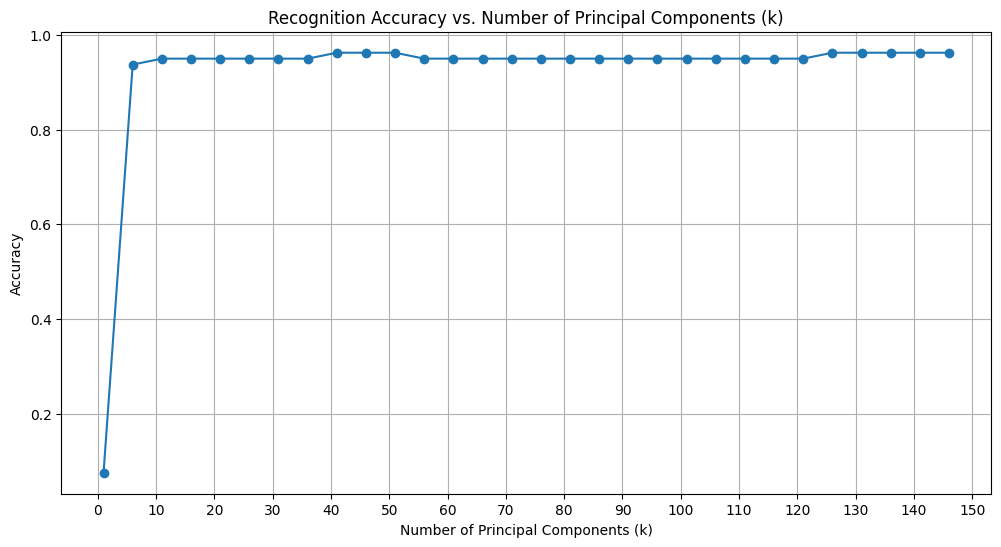


Best performance found at k = 41 with an accuracy of 96.25%.


In [15]:
# Calculate accuracy for a range of k values
k_range = list(range(1, 151, 5)) # Test k from 1 to 150 with a step of 5
accuracies = []

print("Calculating accuracies for different k values...")
for k in k_range:
    acc = calculate_accuracy(k, X_train_std, y_train, X_test_std, y_test, sorted_eigenvectors)
    accuracies.append(acc)
    if k % 25 == 1: # Print progress
        print(f"  k={k}, Accuracy={acc*100:.2f}%")

print("Calculation complete.")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(k_range, accuracies, marker='o', linestyle='-')
plt.title("Recognition Accuracy vs. Number of Principal Components (k)")
plt.xlabel("Number of Principal Components (k)")
plt.ylabel("Accuracy")
plt.xticks(np.arange(0, 151, 10))
plt.grid(True)
plt.show()

# Find the best k and the corresponding accuracy
best_k_index = np.argmax(accuracies)
best_k = k_range[best_k_index]
best_accuracy = accuracies[best_k_index]
print(f"\nBest performance found at k = {best_k} with an accuracy of {best_accuracy * 100:.2f}%.")

In [16]:
def get_predictions(k, X_train_std, y_train, X_test_std, eigenvectors):
    """Gets the predicted labels for the test set for a given k."""
    eigenvectors_k = eigenvectors.real[:, :k]
    
    # Project data
    projected_train = X_train_std @ eigenvectors_k
    projected_test = X_test_std @ eigenvectors_k
    
    predictions = []
    for i in range(len(projected_test)):
        predicted_label = nearest_neighbor_classifier(projected_train, y_train, projected_test[i])
        predictions.append(predicted_label)
            
    return np.array(predictions)

# Get predictions using the best k from the previous analysis
y_pred = get_predictions(best_k, X_train_std, y_train, X_test_std, sorted_eigenvectors)

print(f"Predictions generated for k={best_k}.")

Predictions generated for k=41.


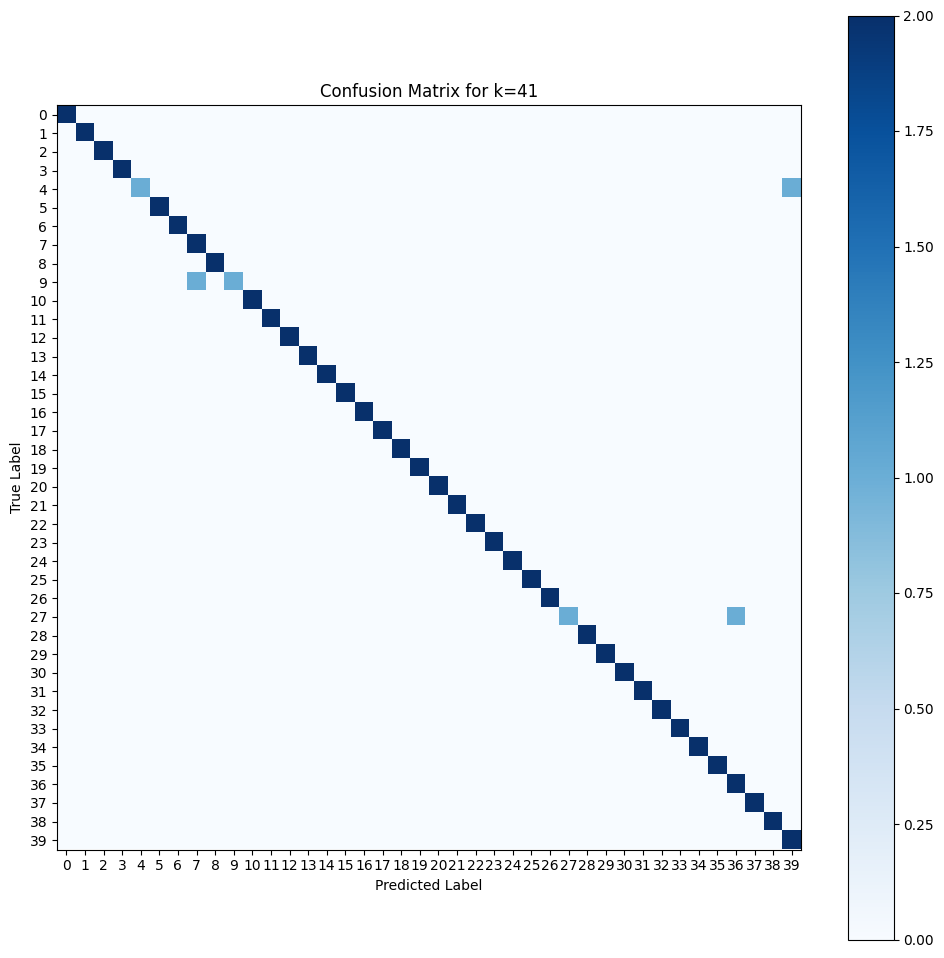

In [17]:
def compute_confusion_matrix(y_true, y_pred, num_classes):
    """Computes a confusion matrix using NumPy."""
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
    for i in range(len(y_true)):
        conf_matrix[y_true[i], y_pred[i]] += 1
    return conf_matrix

# There are 40 unique subjects (classes 0-39)
num_classes = 40 
confusion_mat = compute_confusion_matrix(y_test, y_pred, num_classes)

# Display the confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(confusion_mat, cmap='Blues')

# Add labels and a color bar
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title(f"Confusion Matrix for k={best_k}")
plt.colorbar(im)
plt.show()

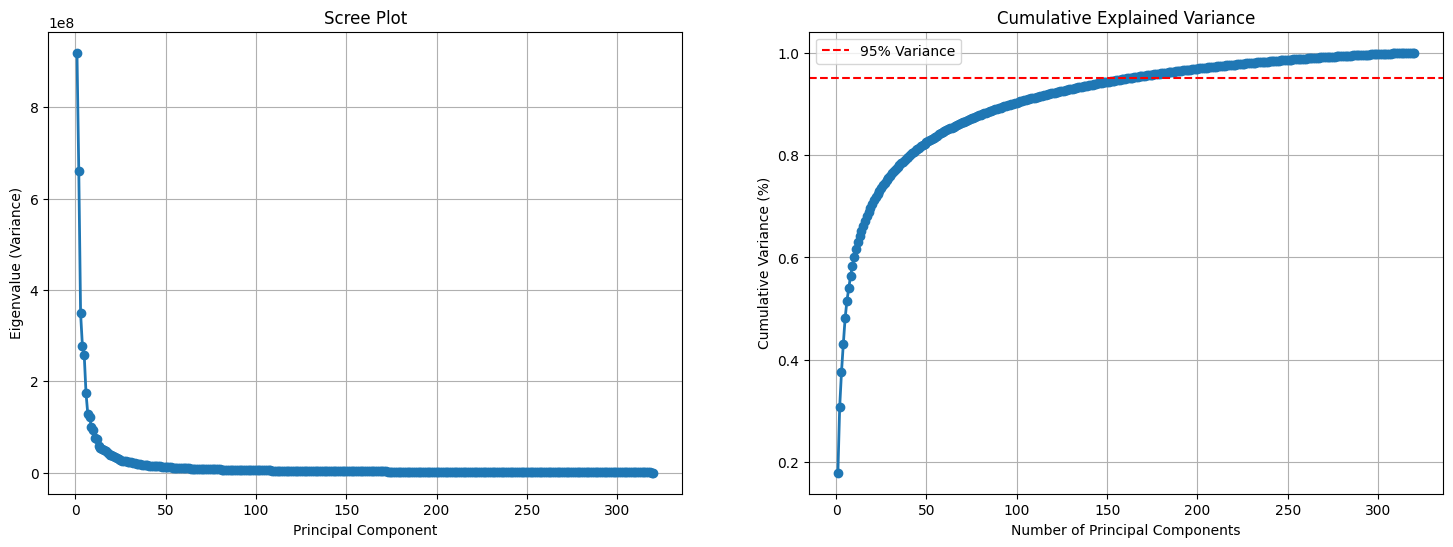

Number of components needed to capture 95% of variance: 162


In [18]:
# The eigenvalues correspond to the variance explained by each component
# We only consider the eigenvalues corresponding to our sample size
valid_eigenvalues = sorted_eigenvalues[:len(X_train)].real

# Calculate explained variance
explained_variance_ratio = valid_eigenvalues / np.sum(valid_eigenvalues)
cumulative_variance = np.cumsum(explained_variance_ratio)

# Create the plots
plt.figure(figsize=(18, 6))

# Scree Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(valid_eigenvalues) + 1), valid_eigenvalues, 'o-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue (Variance)')
plt.grid(True)

# Cumulative Variance Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'o-', linewidth=2)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance (%)')
# Add a line for 95% variance
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.legend()
plt.grid(True)

plt.show()

# Find how many components are needed for 95% variance
components_for_95_variance = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components needed to capture 95% of variance: {components_for_95_variance}")

Running t-SNE... This may take a moment.


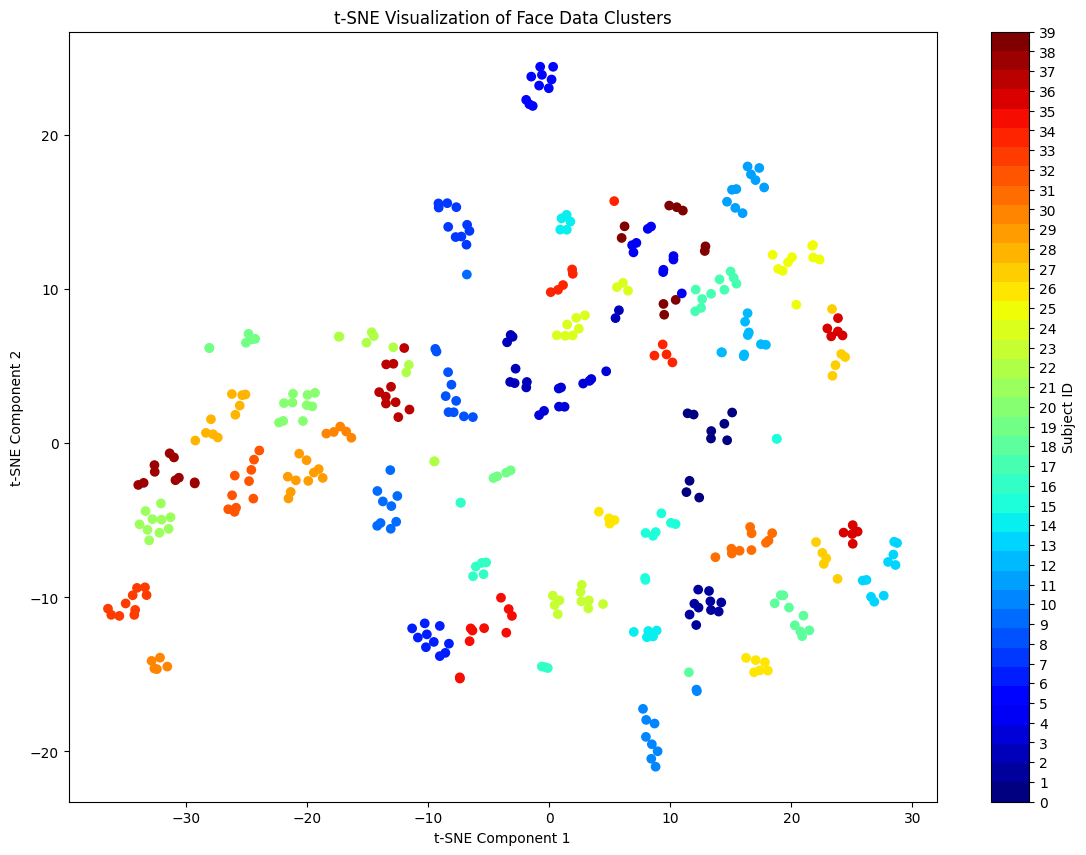

In [19]:
from sklearn.manifold import TSNE

print("Running t-SNE... This may take a moment.")

# First, let's get the PCA features for the entire dataset using the best k
# We combine the standardized train and test sets
X_std_all = np.vstack((X_train_std, X_test_std))
y_all = np.concatenate((y_train, y_test))

# Project all data into the PCA space using the best k
eigenvectors_k = sorted_eigenvectors.real[:, :best_k]
pca_features = X_std_all @ eigenvectors_k

# Initialize and run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(pca_features)

# Plot the results
plt.figure(figsize=(14, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_all, cmap=plt.get_cmap('jet', 40))
plt.title('t-SNE Visualization of Face Data Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, ticks=range(40), label='Subject ID')
plt.show()